# Sequence specificities of RNA-binding proteins with convolutional neural networks

In this tutorial, we will walk through an example of how use deepomics to build, train, and evaluate a convolutional neural network for a common supervised regression learning task of predicting the sequence specificity of a RNA binding protein twoards RNA probe sequences in the RNAcompete dataset. Deepomics is a higher level API that allows you to quickly build different neural network architectures, modify hyperparameters all while keeping track of the feed_dict.  It also allows for easier evaluation of neural networks for biological sequence data. 

To get deepomics:

! git clone https://github.com/p-koo/deepomics

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os, sys, h5py
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from deepomics import neuralnetwork as nn
from deepomics import utils, fit, visualize, saliency

# Load an RNAcompete experiment

Here we will employ a CNN on experimental data from the RNAcompete dataset. The sequences were preprocessed by converting the sequences to a one-hot representation. We generated structural profiles of paired-unpaired probabilities for each nucleotide with RNAplfold.   The affinity intensities were normalized with a log-transformation (details are not important for this tutorial).  

Note that the training sequences (X_train) have a shape of [37187, 39, 6].  The sequence lengths are 39 (some are shorter but have been padded with zeros to make them all the same size).  The 6 represents the 4 nucleotide channels and 2 channels for paired and unpaired. 
Although tensorflow supports a 1D convolution function, tensorflow was designed with 2D images in mind, so there is way better support for the 2D functions.  We can use these 2D functions by adding another 'ornamental' dimension.  

In [2]:
# path to dataset 
data_file_path = '../data/VTS1.h5'

# load dataset
dataset = h5py.File(data_file_path, 'r')
X_train = np.array(dataset['X_train']).astype(np.float32)
Y_train = np.array(dataset['Y_train']).astype(np.float32)
X_valid = np.array(dataset['X_valid']).astype(np.float32)
Y_valid = np.array(dataset['Y_valid']).astype(np.float32)
X_test = np.array(dataset['X_test']).astype(np.float32)
Y_test = np.array(dataset['Y_test']).astype(np.float32)

# add another dimension to make it a 4D tensor and 
# transpose dimensions so that it matches convolutional layer inputs:
#                  (batch size, sequence length, 1, nucleotide channels)
#    Note: adding an additional dimension is required because we will be using 2D convolution functions,
#          because tensorflow doesn't support a lot of functions for 1D sequences.  Effectively, its like
#          treating second dimension as an image with one pixel in one axis.
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)
X_valid = np.expand_dims(X_valid, axis=2)


# Note: deepomics takes as input a dictionary for each dataset
train = {'inputs': X_train, 'targets': Y_train}
valid = {'inputs': X_valid, 'targets': Y_valid}
test = {'inputs': X_test, 'targets': Y_test}

# build our convolutional neural network model 

Our model will be similar to DeepBind: one convolutional layer, one fully-connected hidden layer, followed by an output layer.  Note that the major difference between this CNN and the one for TFs is that here we need to perform a regression task.  So, the output activation is linear and the objective is now a squared_error.  

In [3]:
def cnn_model(input_shape, output_shape):
    
    layer1 = {'layer': 'input', #200          
              'input_shape': input_shape
             }
    layer2 = {'layer': 'conv1d',        # input, conv1d, dense, conv1d_residual, dense_residual, conv1d_transpose, + more
              'num_filters': 32,
              'filter_size': 12,
              'norm': 'batch',          # if removed, automatically adds bias instead
              'activation': 'relu',     # or leaky_relu, prelu, sigmoid, tanh, etc
              'dropout': 0.2,           # if removed, default is no dropout
              'padding': 'VALID',       # VALID OR SAME
              'max_pool': 10,           
             }
    layer3 = {'layer': 'dense',
              'num_units': 128,
              'norm': 'batch',
              'activation': 'relu',
              'dropout': 0.5,
             }
    layer4 = {'layer': 'dense',
              'num_units': output_shape[1],
              'activation': 'linear'
             }

    model_layers = [layer1, layer2, layer3, layer4]

    # optimization parameters
    optimization = {"objective": "squared_error",     # binary, categorical, squared_error, elbo
                    "optimizer": "adam",       # adam, sgd, momentum, rmsprop, adagrad
                    "learning_rate": 0.0003,  
                    "l2": 1e-6,
                    #"label_smoothing": 0.05,
                    #"l1": 1e-6,
                    }
    return model_layers, optimization


# get shapes of inputs and targets
input_shape = list(train['inputs'].shape)
input_shape[0] = None
output_shape = train['targets'].shape

# load model parameters
model_layers, optimization = cnn_model(input_shape, output_shape)

# build neural network class
nnmodel = nn.NeuralNet(seed=247)
nnmodel.build_layers(model_layers, optimization)

# compile neural trainer
save_path = utils.make_directory('../results', 'VTS1')
param_path = os.path.join(save_path, 'deepomics_cnn')
nntrainer = nn.NeuralTrainer(nnmodel, save='best', file_path=param_path)

In [4]:
# look at the shapes of each layer
nnmodel.inspect_layers()

----------------------------------------------------------------------------
Network architecture:
----------------------------------------------------------------------------
layer1: inputs
(?, 39, 1, 6)
layer2: conv1d_0
(?, 28, 1, 32)
layer3: conv1d_0_batch
(?, 28, 1, 32)
layer4: conv1d_0_active
(?, 28, 1, 32)
layer5: conv1d_0_maxpool
(?, 3, 1, 32)
layer6: conv1d_0_dropout
(?, 3, 1, 32)
layer7: dense_0
(?, 128)
layer8: dense_0_batch
(?, 128)
layer9: dense_0_active
(?, 128)
layer10: dense_0_dropout
(?, 128)
layer11: dense_1
(?, 1)
layer12: dense_1_bias
(?, 1)
layer13: output
(?, 1)
----------------------------------------------------------------------------


# start a session

In [5]:
# initialize session
sess = utils.initialize_session()

# train the neural network

In [6]:
# fit model
data = {'train': train, 'valid': valid}
fit.train_minibatch(sess, nntrainer, data, 
                    batch_size=100, 
                    num_epochs=50,
                    patience=10, 
                    verbose=2, 
                    shuffle=True, 
                    save_all=False)

Epoch 1 out of 50 
[==============================] 100.0% -- time=3s -- loss=1.38640 
  valid loss:		0.91954
  valid Pearson's R:	0.40349+/-0.00000
  valid rsquare:	0.10346+/-0.00000
  valid slope:		0.65448+/-0.00000
  lower cross-validation found
  saving model to:  ../results/VTS1/deepomics_cnn_best.ckpt
Epoch 2 out of 50 
[==============================] 100.0% -- time=2s -- loss=0.90124 
  valid loss:		0.81846
  valid Pearson's R:	0.50605+/-0.00000
  valid rsquare:	0.18011+/-0.00000
  valid slope:		0.87602+/-0.00000
  lower cross-validation found
  saving model to:  ../results/VTS1/deepomics_cnn_best.ckpt
Epoch 3 out of 50 
[==============================] 100.0% -- time=2s -- loss=0.81576 
  valid loss:		0.78685
  valid Pearson's R:	0.55111+/-0.00000
  valid rsquare:	0.21218+/-0.00000
  valid slope:		0.88370+/-0.00000
  lower cross-validation found
  saving model to:  ../results/VTS1/deepomics_cnn_best.ckpt
Epoch 4 out of 50 
[==============================] 100.0% -- time=2s -- 

[==============================] 100.0% -- time=2s -- loss=0.54833 
  valid loss:		0.57250
  valid Pearson's R:	0.67290+/-0.00000
  valid rsquare:	0.43626+/-0.00000
  valid slope:		1.18957+/-0.00000
Epoch 31 out of 50 
[==============================] 100.0% -- time=2s -- loss=0.54943 
  valid loss:		0.55402
  valid Pearson's R:	0.67253+/-0.00000
  valid rsquare:	0.44905+/-0.00000
  valid slope:		1.09365+/-0.00000
Epoch 32 out of 50 
[==============================] 100.0% -- time=2s -- loss=0.54926 
  valid loss:		0.56034
  valid Pearson's R:	0.67546+/-0.00000
  valid rsquare:	0.44134+/-0.00000
  valid slope:		1.08841+/-0.00000
Epoch 33 out of 50 
[==============================] 100.0% -- time=2s -- loss=0.54691 
  valid loss:		0.56155
  valid Pearson's R:	0.67246+/-0.00000
  valid rsquare:	0.43893+/-0.00000
  valid slope:		1.07211+/-0.00000
Epoch 34 out of 50 
[==============================] 100.0% -- time=2s -- loss=0.54359 
  valid loss:		0.55031
  valid Pearson's R:	0.67324+/-0.

In [7]:
# set best parameters
nntrainer.set_best_parameters(sess)

# test model
loss, mean_vals, std_vals = nntrainer.test_model(sess, test, name='test')

loading model from:  ../results/VTS1/deepomics_cnn_best.ckpt
INFO:tensorflow:Restoring parameters from ../results/VTS1/deepomics_cnn_best.ckpt
  test  loss:		0.57093
  test  Pearson's R:	0.65615+/-0.00000
  test  rsquare:	0.42901+/-0.00000
  test  slope:		1.00139+/-0.00000


# get predictions

Note: the activations of any layer can be extracted by giving the layer name.

/usr/lib/python2.7/dist-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


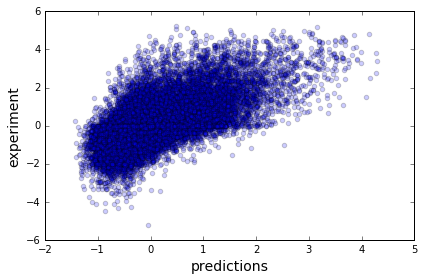

In [8]:
# calculate activations
predictions = nntrainer.get_activations(sess, test, layer='output')

plt.figure()
plt.scatter(predictions[:,0], test['targets'][:,0], alpha=0.2)
plt.xlabel('predictions', fontsize=14)
plt.ylabel('experiment', fontsize=14)

# close session

In [9]:
# close session
sess.close()

# Let's plot saliency maps for the highest predicted sequences

INFO:tensorflow:Restoring parameters from ../results/VTS1/deepomics_cnn_best.ckpt
INFO:tensorflow:Restoring parameters from ../results/VTS1/deepomics_cnn_best.ckpt
INFO:tensorflow:Restoring parameters from ../results/VTS1/deepomics_cnn_best.ckpt
INFO:tensorflow:Restoring parameters from ../results/VTS1/deepomics_cnn_best.ckpt
INFO:tensorflow:Restoring parameters from ../results/VTS1/deepomics_cnn_best.ckpt


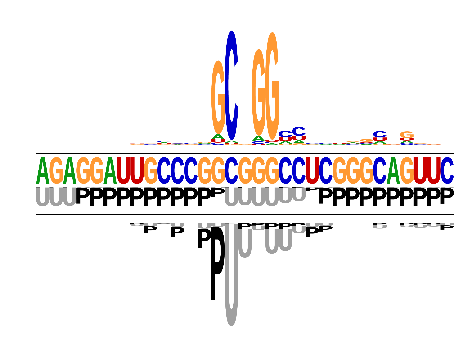

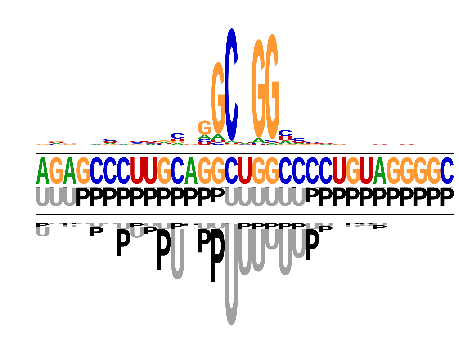

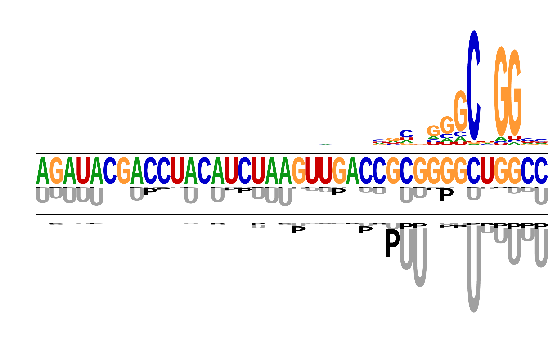

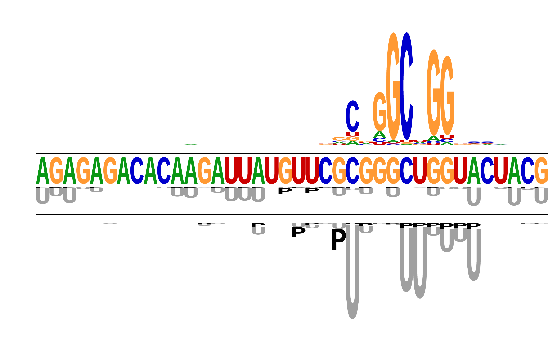

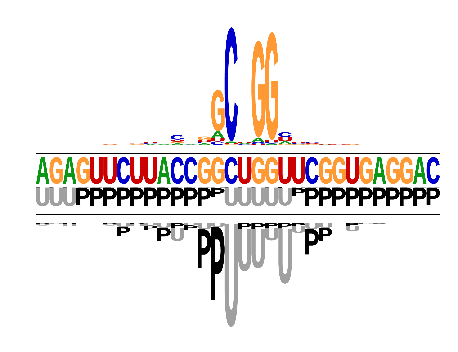

In [10]:
# sort predictions
plot_index = np.argsort(predictions[:,0])[::-1]

# saliency parameters  <-- neccessary because we need to rebuild graph using different gradient ops
params = {'genome_model': cnn_model, 
          'input_shape': input_shape, 
          'output_shape': output_shape, 
          'optimization': optimization,
          'model_path': param_path+'_best.ckpt',
         }

# plot saliency of top activations
num_plots = 5
for index in plot_index[:num_plots]:

        X = np.expand_dims(test['inputs'][index], axis=0)

        # guided backprop
        guided_saliency = saliency.guided_backprop(X, layer='output', class_index=None, params=params)

        # plot and save saliency
        fig = plt.figure(figsize=(10,5))
        visualize.plot_seq_struct_saliency(np.squeeze(X).T, 
                                            np.squeeze(guided_saliency[0]).T, 
                                            nt_width=100)
        #outfile = os.path.join(save_path, str(index)+'_saliency_.pdf')
        #fig.savefig(outfile, format='pdf', dpi=200, bbox_inches='tight') 
        #plt.close()